### 경로 데이터 불러오기


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import copy

filenames = []
# CSV 파일에서 경로 데이터를 추출하는 함수
def extract_lat_lng_from_csv(directory):
    all_lat_lng_lists = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filenames.append(filename)
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            lat_lng_list = [(row['lat'], row['lng']) for index, row in df.iterrows()]
            all_lat_lng_lists.append(lat_lng_list)
    return all_lat_lng_lists

# 경로 데이터를 읽어오는 경로 설정
directory_path = "../어디쉐어/어디쉐어 dbscan_padding"
lat_lng_values = extract_lat_lng_from_csv(directory_path)
path_backup = copy.deepcopy(lat_lng_values)

### 경로 벡터화

In [2]:
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import normalize
import numpy as np

# 고정된 크기의 벡터로 변환하기 위한 함수
def vectorize_path(path, vector_size=20):
    # 패딩 또는 트리밍을 통해 길이를 고정합니다.
    if len(path) < vector_size:
        path += [(0, 0)] * (vector_size - len(path))  # 패딩
    else:
        step = len(path) / vector_size
        path = [path[int(i * step)] for i in range(vector_size)]  # 샘플링
    
    # 벡터화하여 평탄화합니다.
    vector = np.array(path).flatten()
    return vector

# 모든 경로 데이터를 벡터화합니다.
vectorized_paths = np.array([vectorize_path(path) for path in lat_lng_values])

# 정규화(옵션, 선택사항)
vectorized_paths = normalize(vectorized_paths)
print('vectorized_paths',vectorized_paths)
# print(f"Vectorized Path 1: {vectorized_paths[0]}")


vectorized_paths [[0.07881387 0.26591623 0.07881373 ... 0.         0.         0.        ]
 [0.16404506 0.55355396 0.16405145 ... 0.         0.         0.        ]
 [0.14206796 0.47939499 0.14206783 ... 0.         0.         0.        ]
 ...
 [0.19996907 0.67824212 0.19996907 ... 0.         0.         0.        ]
 [0.11601455 0.39260344 0.11585151 ... 0.         0.         0.        ]
 [0.16407182 0.55354631 0.16407206 ... 0.         0.         0.        ]]


### 최적 파라미터

[0.00055939 0.00056195 0.00085891 0.00105427 0.0010663  0.00106746
 0.00106827 0.00107664 0.00107664 0.00108927 0.00109677 0.00143514
 0.00159524 0.00178901 0.00179747 0.00285273 0.0034198  0.00443203
 0.00612445 0.00703283 0.0081467  0.01612077 0.01648847 0.01660664
 0.26050803 0.26050829 0.26051362 0.26051362 0.2605673  0.26101967
 0.32044288 0.32044383 0.33819578 0.33826678 0.35939912 0.35941313
 0.35944306 0.37161507]
eps_opt:0.006578641784567036


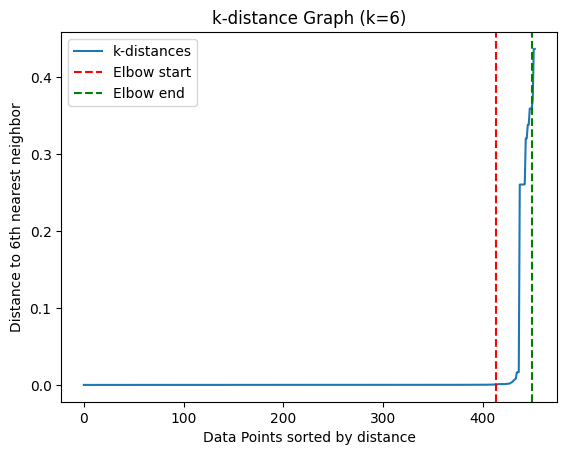

In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import statistics


# k 값을 설정 (예: 4)
k = 6

# NearestNeighbors 모델을 사용하여 이웃 계산
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(vectorized_paths)

# 각 데이터 포인트의 k번째 이웃까지의 거리 계산
distances, indices = neigh.kneighbors(vectorized_paths)

# k번째 이웃까지의 거리만 추출 (k번째 이웃의 거리를 사용)
k_distances = distances[:, -1]

# k-거리를 오름차순으로 정렬
k_distances = np.sort(k_distances)

# k-거리의 차이 계산 (기울기)
gradients = np.diff(k_distances)

# 기울기의 변화량 계산
gradients_diff = np.diff(gradients)

# 급격한 변화가 발생하는 인덱스 찾기 (최초의 큰 변화 찾기)
threshold = np.percentile(gradients_diff, 97)  # 기울기 변화 중 상위 5%를 임계값으로 설정
elbow_start = np.argmax(gradients_diff > threshold)  # 첫 번째 급격한 변화 지점
elbow_end = len(gradients_diff) - np.argmax(np.flip(gradients_diff) > threshold) - 1  # 마지막 급격한 변화 지점

# y-좌표 값 출력 (k-거리)
y_values = k_distances[elbow_start:elbow_end + 2]
print(y_values)
eps_opt=statistics.median(y_values) # 중앙값으로 결정
print(f"eps_opt:{eps_opt}")

# k-거리 그래프 시각화
plt.plot(k_distances, label='k-distances')
plt.axvline(x=elbow_start, color='r', linestyle='--', label='Elbow start')
plt.axvline(x=elbow_end, color='g', linestyle='--', label='Elbow end')
plt.xlabel("Data Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title(f"k-distance Graph (k={k})")
plt.legend()
plt.show()


### DBSCAN 모델로 이상치 판단 및 시각화 (출력 데이터)

eps : 0.006578641784567036
min_samples : 6
정상 data 개수 : 433
비정상 data 개수 : 20
silhouette score :  0.9461838053235782


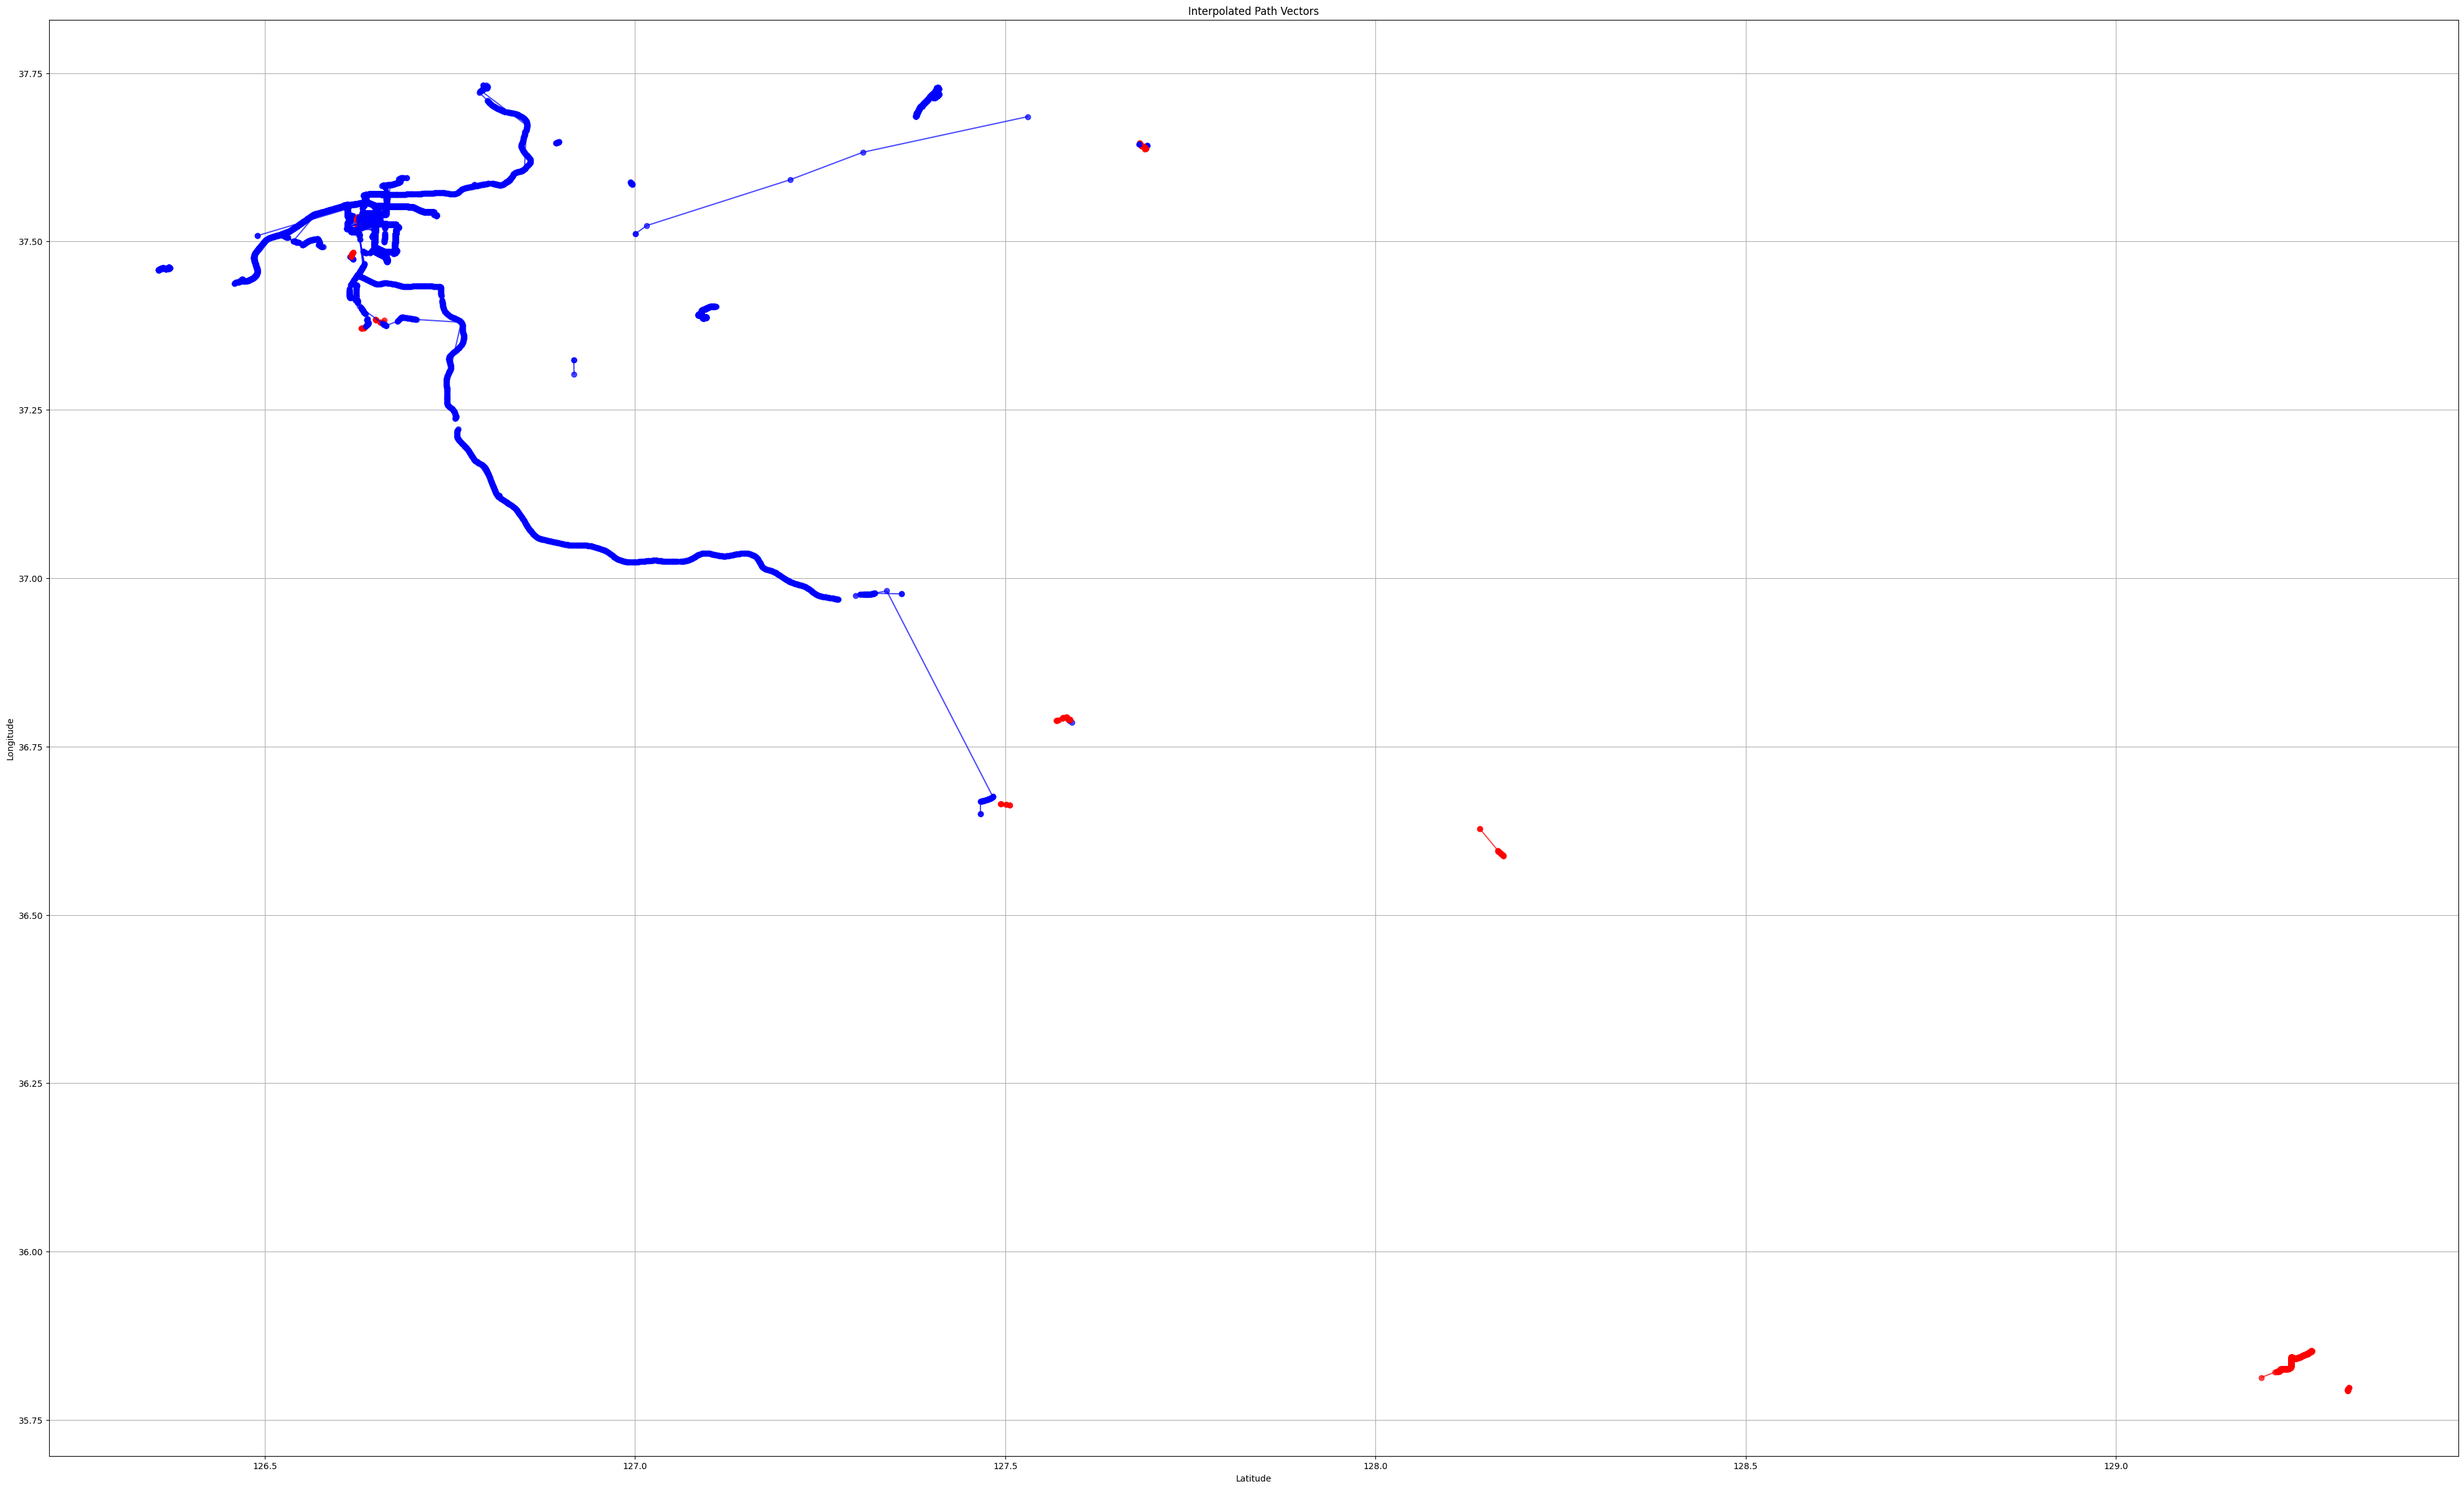

In [4]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

dbscan = DBSCAN(eps=eps_opt, min_samples=k)
labels = dbscan.fit_predict(vectorized_paths)

print(f"eps : {eps_opt}")
print(f"min_samples : {k}")
print(f"정상 data 개수 : {sum(labels!=-1)}")
print(f"비정상 data 개수 : {sum(labels==-1)}")
silhouette_avg = silhouette_score(vectorized_paths, labels)
print('silhouette score : ',silhouette_avg)

plt.figure(figsize=(50, 30))

for i, lat_lng_list in enumerate(path_backup):
    lats, lngs = zip(*lat_lng_list)
    fn = filenames[i]
    if labels[i]==-1:
        col = 'r'
    else:
        col = 'b'
    plt.plot(lngs, lats, marker='o',color = col, alpha=0.7)


plt.title('Interpolated Path Vectors')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.grid(True)
plt.show()

### 이상치 여부를 원본 CSV 파일에 기록

In [5]:
# 이상치 여부를 'dbscan output' 열에 기록하는 함수

def record_outliers(directory, labels, filenames):
 
    for label, filename in zip(labels, filenames):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        if label == -1:
            df['output'] = 'AN'  # 기본값 1로 설정
        else:
            df['output'] = 'N'  # 이상치일 경우 -1로 설정
        df.to_csv(filepath, index=False)

# 이상치 여부를 CSV 파일에 기록
record_outliers(directory_path, labels, filenames)


### DBSCAN 이상경로 파일명 출력

In [6]:
# 이상경로 파일명을 텍스트로 출력하는 함수
def print_outlier_paths_with_filenames(labels, filenames):
    print('--------outlier_paths--------')
    for label, filename in zip(labels, filenames):
        if label == -1:
            print(f"{filenames.index(filename)} | {filename}")

# 이상경로 파일명을 텍스트로 출력
outlier_paths = print_outlier_paths_with_filenames(labels, filenames)


--------outlier_paths--------
0 | 20230415014344.csv
11 | 20230421033510.csv
19 | 20230422082401.csv
41 | 20230430184009.csv
43 | 20230430220837.csv
51 | 20230505122923.csv
52 | 20230505125302.csv
72 | 20230512192628.csv
91 | 20230519175913.csv
154 | 20230610214706.csv
171 | 20230617212016.csv
196 | 20230707194508.csv
213 | 20230715111528.csv
217 | 20230715194033.csv
218 | 20230716140812.csv
331 | 20231001111709.csv
332 | 20231001150901.csv
333 | 20231002105108.csv
334 | 20231003181802.csv
449 | 20231202171651.csv
